In [506]:
import pandas as pd
import sys

# the original intersection data that will be enriched with addtional variables
inter_collis_df = pd.DataFrame.from_csv("./OBJ2B_collisions_intersections.csv")

# the base intersection data that will be enriched with addtional variables
inter_base_df = pd.DataFrame.from_csv("./Intersections_Base.csv")

# alex's predicted street exposure (adt) that will be joined with the streets column of intersection data
street_exp_pred_df = pd.DataFrame.from_csv("../o1_se_result2.tsv", sep="\t")

# original street exposure data that will be selectively joined with streets column of intersection data
street_exp_orig_df = pd.DataFrame.from_csv("./OBJ1_streets_exposure.csv")

# index street data on unitidsort
street_exp_orig_df = street_exp_orig_df.set_index(['unitidsort'])

In [507]:
pd.Series(list(set(inter_base_df.compkey) & set(inter_collis_df.intkey))).count()

2284

In [508]:
# get intersection ids and streets
inter_streets_df = inter_base_df[['compkey','streets']]

In [509]:
# join in all vars from predicted exposure
# results in a new column with list of lists: outer list for each street and inner lists of predicted exposure vars
inter_streets_df["exp_pred_vars"] = inter_streets_df.streets.apply(lambda x: [street_exp_pred_df.ix[int(y)] for y in x.split(',')])

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [510]:
inter_streets_df["exp_pred_vars"].head(2)

0    [[nan, 986.562126055, 6.89422629971], [nan, 55...
1                [[nan, 591.312015075, 6.38234382238]]
Name: exp_pred_vars, dtype: object

In [511]:
# join in all vars from predicted exposure
# results in a new column with list of lists: outer list for each street and inner lists of predicted exposure vars
inter_streets_df["street_vars"] = inter_streets_df.streets.apply(lambda x: [street_exp_orig_df.ix[int(y)] for y in x.split(',')])

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [512]:
inter_streets_df["street_vars"].head(2)

0    [[6600, 42ND AVE SW, 42ND AVE SW BETWEEN SW ED...
1    [[21066, S PEARL ST, S PEARL ST BETWEEN DEAD E...
Name: street_vars, dtype: object

In [513]:
# next we want to perform some aggregations

# these are helper functions that will be used to aggregate over a particular column of street-level data
import math
import sys

def sum_over_streets(column, street_data):
    result = 0
    for street in street_data:
        result += street[column]
        
    return result

def uniq_values(column, street_data):
    values = set()
    for street in street_data:
        values.add(street[column])
        
    return len(values)

def min_known_value(column, street_data):
    minimum = sys.maxint
    for street in street_data:
        if not math.isnan(street[column]):
            if street[column] < minimum:
                minimum = street[column]
        
    if minimum == sys.maxint:
        return float('NaN')
    else:
        return minimum
    
def max_known_value(column, street_data):
    maximum = -sys.maxint - 1
    for street in street_data:
        if not math.isnan(street[column]):
            if street[column] > maximum:
                maximum = street[column]
        
    if maximum == -sys.maxint - 1:
        return float('NaN')
    else:
        return maximum

def min_nonzero_value(column, street_data):
    minimum = sys.maxint
    for street in street_data:
        if street[column] != 0 and street[column] < minimum:
            minimum = street[column]
        
    if minimum == sys.maxint:
        return float('NaN')
    else:
        return minimum

def avg_of_known_values(column, street_data):
    total = 0
    count = 0
    for street in street_data:
        if not math.isnan(street[column]):
            total += street[column]
            count += 1
    if count == 0:
        return float('NaN')
    else:
        return total / float(count)
    
def avg_of_nonzero_values(column, street_data):
    total = 0
    count = 0
    for street in street_data:
        if not street[column] == 0:
            total += street[column]
            count += 1
    if count == 0:
        return float('NaN')
    else:
        return total / float(count)

def bool_true_count(column, street_data):
    count = 0
    for street in street_data:
        if street[column]:
            count += 1
    return count
            
def transit_count(column, street_data):
    count = 0
    for street in street_data:
        if street[column] > 0 and street[column] < 4:
            count += 1
        
    return count

In [514]:
# add variable intersection_adt_hat2: adt_hat2 summed over all streets (and divided by 2)
inter_streets_df["intersection_adt_hat2"] = inter_streets_df.exp_pred_vars.apply(lambda x: sum_over_streets(1, x) / 2.0)

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [515]:
# add variable zoning_cats: number of unique zoning categories over all streets divided by number of streets
inter_streets_df["zoning_cats"] = inter_streets_df.street_vars.apply(lambda x: uniq_values(4, x) / float(len(x)))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [516]:
# add variable min_pavement_cond: min known value of pavement condition index over all streets (some are unknown)
inter_streets_df["min_pavement_cond"] = inter_streets_df.street_vars.apply(lambda x: min_nonzero_value(5, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [517]:
# add variable avg_pavement_cond: avg value of known pavement condition index over all streets (some are unknown)
inter_streets_df["avg_pavement_cond"] = inter_streets_df.street_vars.apply(lambda x: avg_of_nonzero_values(5, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [518]:
# add variable pct_truck_routes: percentage of truck routes over all streets
inter_streets_df["pct_truck_routes"] = inter_streets_df.street_vars.apply(lambda x: bool_true_count(6, x) / float(len(x)))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [519]:
# add variable min_surface_width: min value of known surface widths over all streets (some are unknown)
inter_streets_df["min_surface_width"] = inter_streets_df.street_vars.apply(lambda x: min_known_value(9, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [520]:
# add variable avg_surface_width: average value of known surface widths over all streets (some are unknown)
inter_streets_df["avg_surface_width"] = inter_streets_df.street_vars.apply(lambda x: avg_of_known_values(9, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [521]:
# add variable pct_oneway: percentage of oneway over all streets
inter_streets_df["pct_oneway"] = inter_streets_df.street_vars.apply(lambda x: bool_true_count(10, x) / float(len(x)))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [522]:
# add variable pct_transit: percentage of streets w/ transit route over all streets
inter_streets_df["pct_transit"] = inter_streets_df.street_vars.apply(lambda x: transit_count(11, x) / float(len(x)))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [523]:
# add variable max_speedlimit: max speed limit over streets (where known)
inter_streets_df["max_speedlimit"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(12, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [524]:
# add variable school_50: true if school w/in .5 miles of any street
inter_streets_df["school_50"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(17, x) > 0)

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [525]:
# add variable school_25: true if school w/in .25 miles of any street
inter_streets_df["school_25"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(18, x) > 0)

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [526]:
# add variable univ_50: true if university w/in .5 miles of any street
inter_streets_df["univ_50"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(19, x) > 0)

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [527]:
# add variable univ_25: true if university w/in .25 miles of any street
inter_streets_df["univ_25"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(20, x) > 0)

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [528]:
# add variable tcircle: true if traffic circle on any street
inter_streets_df["tcircle"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(24, x) > 0)

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [529]:
# add variable pct_curb_sw: percentage of streets w/ curbed sidewalk
inter_streets_df["pct_curb_sw"] = inter_streets_df.street_vars.apply(lambda x: sum_over_streets(26, x) / float(len(x)))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [530]:
# add variable max_angle: max street angle over streets (where known)
inter_streets_df["max_angle"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(27, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [531]:
# add variable bikeshare_150: count of bikeshare stations w/ 150ft of streets (where known)
inter_streets_df["bikeshare_150"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(55, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [532]:
# add variable transit_routes: max number of transit routes of any street
inter_streets_df["transit_routes"] = inter_streets_df.street_vars.apply(lambda x: max_known_value(65, x))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [533]:
# add variable pct_streetcar: percentage of streets w/ streetcar
inter_streets_df["pct_streetcar"] = inter_streets_df.street_vars.apply(lambda x: sum_over_streets(67, x) / float(len(x)))

/Users/rmegraw/anaconda-4.3.1/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [534]:
inter_streets_df["pct_streetcar"][inter_streets_df["pct_streetcar"] > 0]

746      0.750000
888      0.250000
1108     0.333333
1214     0.666667
1466     0.500000
1850     1.000000
1851     0.250000
2041     0.500000
2061     0.666667
2145     0.750000
2266     0.250000
2343     0.500000
2458     0.750000
2526     0.250000
2745     0.750000
2749     0.166667
2814     0.750000
3460     0.250000
3555     0.500000
4334     0.250000
4347     0.250000
4745     0.250000
4785     0.750000
4794     0.666667
4877     0.250000
4935     0.250000
4954     0.500000
4988     0.500000
5102     0.250000
5183     0.750000
           ...   
10366    0.250000
10367    0.750000
10754    1.000000
10767    0.500000
10786    0.500000
11226    1.000000
11473    0.750000
11486    0.500000
11939    0.500000
12099    1.000000
13735    1.000000
14053    0.500000
14067    0.250000
14146    1.000000
14194    0.500000
14211    0.250000
14356    0.250000
14718    0.250000
14921    0.500000
14940    0.250000
15046    0.250000
15219    0.250000
15227    0.666667
15246    1.000000
15248    0

In [535]:
inter_streets_df["pct_curb_sw"][inter_streets_df["pct_curb_sw"] == True].count()

8293

In [536]:
inter_streets_df

,compkey,streets,exp_pred_vars,street_vars,intersection_adt_hat2,zoning_cats,min_pavement_cond,avg_pavement_cond,pct_truck_routes,min_surface_width,...,school_50,school_25,univ_50,univ_25,tcircle,pct_curb_sw,max_angle,bikeshare_150,transit_routes,pct_streetcar
0,32771,"034200480, 034200500, 178550410, 178550420","[[nan, 986.562126055, 6.89422629971], [nan, 55...","[[6600, 42ND AVE SW, 42ND AVE SW BETWEEN SW ED...",1761.168462,0.250000,53.0,59.333333,0.000000,25.0,...,False,False,False,False,True,1.000000,271.803,0,0,0.00
1,33084,167550100,"[[nan, 591.312015075, 6.38234382238]]","[[21066, S PEARL ST, S PEARL ST BETWEEN DEAD E...",295.656008,1.000000,100.0,100.000000,0.000000,23.0,...,True,True,False,False,False,1.000000,83.196,0,0,0.00
2,33085,"061150500, 061150510, 167550100, 167550110","[[nan, 851.694543702, 6.74722794576], [nan, 70...","[[9824, CORSON AVE S, CORSON AVE S BETWEEN S H...",1435.101633,0.250000,72.0,83.250000,0.000000,23.0,...,True,True,False,False,False,1.000000,193.477,0,0,0.00
3,30493,"021000010, 021000020, 171400021, 171400030","[[2537.0, 2486.69366072, 7.81870925999], [2842...","[[4514, 3RD AVE S, 3RD AVE S BETWEEN YESLER WA...",4907.121592,0.250000,13.0,13.000000,0.000000,34.0,...,False,False,False,False,False,1.000000,184.363,0,31,0.00
4,33234,"019200500, 019200504, 157100270","[[nan, 223.179132756, 5.4079747349], [nan, 361...","[[4194, 28TH AVE S, 28TH AVE S BETWEEN S HUDSO...",443.084634,0.333333,84.0,84.000000,0.000000,25.0,...,True,True,False,False,False,1.000000,181.613,0,0,0.00
5,33235,"021650490, 021650500, 021650520, 157100290, 15...","[[nan, 410.097150075, 6.01639408303], [nan, 57...","[[4700, 30TH AVE S, 30TH AVE S BETWEEN S FERDI...",1175.125735,0.200000,81.0,89.750000,0.000000,19.0,...,True,True,False,False,False,0.000000,181.373,0,0,0.00
6,33236,"020250486, 020250520, 157100280, 157100290","[[nan, 307.192880054, 5.7274758241], [nan, 327...","[[4327, 29TH AVE S, 29TH AVE S BETWEEN S EDMUN...",766.680670,0.250000,72.0,81.250000,0.000000,20.0,...,True,True,False,False,False,0.000000,181.559,0,0,0.00
7,33237,"019200504, 019200520, 157100280","[[nan, 361.265394888, 5.88961285413], [nan, 24...","[[4195, 28TH AVE S, 28TH AVE S BETWEEN S DAWSO...",469.458199,0.333333,80.0,80.500000,0.000000,22.0,...,True,True,False,False,False,0.666667,181.613,0,0,0.00
8,33246,"014900520, 014900530, 154500235, 154500240","[[nan, 837.194547192, 6.7300564774], [nan, 266...","[[163664, 24TH AVE S, 24TH AVE S BETWEEN DEAD ...",1056.187045,0.250000,78.0,86.666667,0.000000,10.0,...,True,False,False,False,False,0.000000,179.839,0,0,0.00
9,33250,"020250530, 154850280, 154850290","[[nan, 290.718819897, 5.6723565454], [nan, 346...","[[337692, 29TH AVE S, 29TH AVE S BETWEEN S BEN...",598.523582,0.333333,78.0,82.333333,0.000000,20.0,...,True,True,False,False,False,0.000000,171.776,0,0,0.00


In [537]:
# first drop temporary columns
inter_streets_df = inter_streets_df.drop('street_vars', axis=1)
inter_streets_df.drop('exp_pred_vars', axis=1, inplace=True)
inter_streets_df.drop('streets', axis=1, inplace=True)

# index on compkey
inter_streets_df = inter_streets_df.set_index(['compkey'])
inter_collis_df = inter_collis_df.set_index(['intkey'])
inter_base_df = inter_collis_df.set_index(['compkey'])

# join inter_streets_df with intersections base and collisions
inter_collis_expanded_df = inter_collis_df.join(inter_streets_df, how='inner')
inter_base_expanded_df = inter_base_df.join(inter_streets_df, how='inner')

print "expanded " + str(len(inter_collis_expanded_df)) + " orig " + str(len(inter_collis_df))
print "expanded " + str(len(inter_base_expanded_df)) + " orig " + str(len(inter_base_df))


expanded 6198 orig 6198
expanded 6198 orig 6198


In [538]:
inter_collis_expanded_df.head(2)

,gid,segkey,location,incdttm,yr,mon,hr,dow,col_type,st_colcode,...,school_50,school_25,univ_50,univ_25,tcircle,pct_curb_sw,max_angle,bikeshare_150,transit_routes,pct_streetcar
23843,68746,5250.0,34TH AVE NW AND NW 68TH ST,5/24/2009 9:09:00 AM,2009.0,5.0,9.0,0.0,Cycles,45,...,False,False,False,False,True,1.0,359.561,0,0,0.0
23860,95654,2119.0,15TH AVE NW AND NW 83RD ST,9/6/2011,2011.0,9.0,NaN,2.0,Cycles,45,...,True,False,False,False,True,1.0,272.190,0,4,0.0


In [539]:
len(pd.Series(list(set(inter_collis_expanded_df.index) & set(inter_base_expanded_df.index))))

2284

In [540]:
# write to file
inter_collis_expanded_df.to_csv('./collisions_intersections_rod.tsv', sep="\t", index=True)
inter_base_expanded_df.to_csv('./base_intersections_rod.tsv', sep="\t", index=True)

In [541]:
list(inter_collis_expanded_df.columns)

['gid',
 'segkey',
 'location',
 'incdttm',
 'yr',
 'mon',
 'hr',
 'dow',
 'col_type',
 'st_colcode',
 'st_coldesc',
 'sdot_colco',
 'sdot_colde',
 'junctionty',
 'addrtype',
 'pedcount',
 'vehcount',
 'personcoun',
 'pedcylcoun',
 'injuries',
 'severityco',
 'severityde',
 'seriousinj',
 'fatalities',
 'inattent',
 'pedrownotg',
 'speeding',
 'underinfl',
 'rd_cond',
 'weather',
 'lightcond',
 'compkey',
 'neihborhood',
 'unitdesc',
 'x',
 'y',
 'streets',
 'max_artclass',
 'num_undsg',
 'num_notrfl',
 'elev',
 'at_slopes',
 'avg_slope',
 'max_slope',
 'min_slope',
 'has_signal',
 'sig_type',
 'degree',
 'bus_stops',
 'lanetyps',
 'alllanes',
 'trafflanes',
 'max_trflan',
 'thru_lane',
 'lt_lane',
 'lt2_lane',
 'rt_lane',
 'rt2_lane',
 'bklane',
 'bkm_lane',
 'bus_lane',
 'offon_ramp',
 'onoff_ndist',
 'pkng',
 'pk_met',
 'parkgar',
 'parkgar_avg',
 'cw_count',
 'pop_p25',
 'jobs_p25',
 'winc_p25',
 'com_dnty',
 'oth_dnty',
 'res_dnty',
 'pk_dnty',
 'area_far',
 'nbldg',
 'max_stories

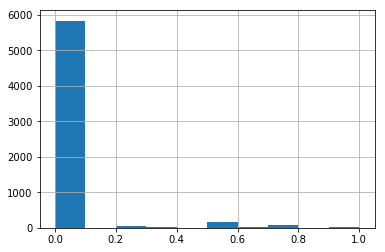

In [553]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

inter_collis_expanded_df.pct_streetcar.hist()